In [1]:
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/average-monthly-surface-temperature.csv')

df.head()

,Entity,Code,year,Day,Average surface temperature,Average surface temperature.1
0,Afghanistan,AFG,1940,1940-01-15,-2.032494,11.327695
1,Afghanistan,AFG,1940,1940-02-15,-0.733503,11.327695
2,Afghanistan,AFG,1940,1940-03-15,1.999134,11.327695
3,Afghanistan,AFG,1940,1940-04-15,10.199754,11.327695
4,Afghanistan,AFG,1940,1940-05-15,17.942135,11.327695


In [3]:
# Переименование столбцов
df = df.rename(columns={
    'Entity': 'Country',
    'year': 'Year',
    'Average surface temperature': 'Daily average temp',
    'Average surface temperature.1': 'Yearly average temp'
})

df = df.drop(columns=['Code'])

# Преобразование столбца Day в формат datetime
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month

print(df.head())

       Country  Year        Day  Daily average temp  Yearly average temp  \
0  Afghanistan  1940 1940-01-15           -2.032494            11.327695   
1  Afghanistan  1940 1940-02-15           -0.733503            11.327695   
2  Afghanistan  1940 1940-03-15            1.999134            11.327695   
3  Afghanistan  1940 1940-04-15           10.199754            11.327695   
4  Afghanistan  1940 1940-05-15           17.942135            11.327695   

   Month  
0      1  
1      2  
2      3  
3      4  
4      5  


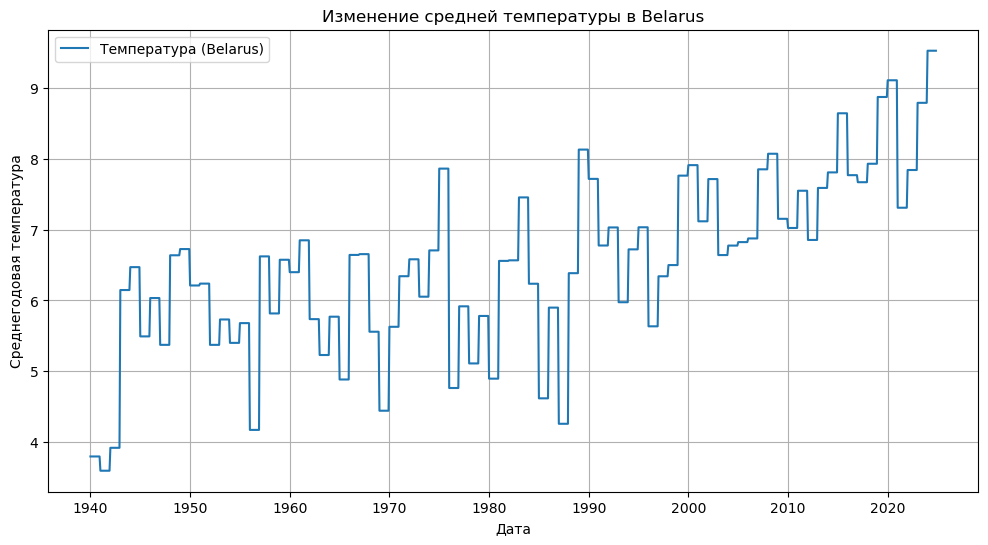

In [4]:
# Целевая переменная: прогноз температуры следующего дня
df['Target'] = df.groupby('Country')['Daily average temp'].shift(-1)

# Удаляем строки с NaN (из-за сдвига цели)
df = df.dropna()

df = df.sort_values(by=['Country', 'Year'])

# Пример: Визуализация временного ряда для конкретной страны
country_name = "Belarus"
country_data = df[df['Country'] == country_name]

# Создание временного индекса с использованием .loc для безопасной модификации
country_data = df.loc[df['Country'] == country_name].copy()  # Создаем копию, чтобы избежать дальнейших предупреждений
country_data['Date'] = pd.to_datetime(country_data[['Year', 'Month']].assign(DAY=1))
country_data = country_data.set_index('Date').sort_index()

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(country_data['Yearly average temp'], label=f"Температура ({country_name})")
plt.title(f"Изменение средней температуры в {country_name}")
plt.xlabel("Дата")
plt.ylabel("Среднегодовая температура")
plt.legend()
plt.grid(True)
plt.show()

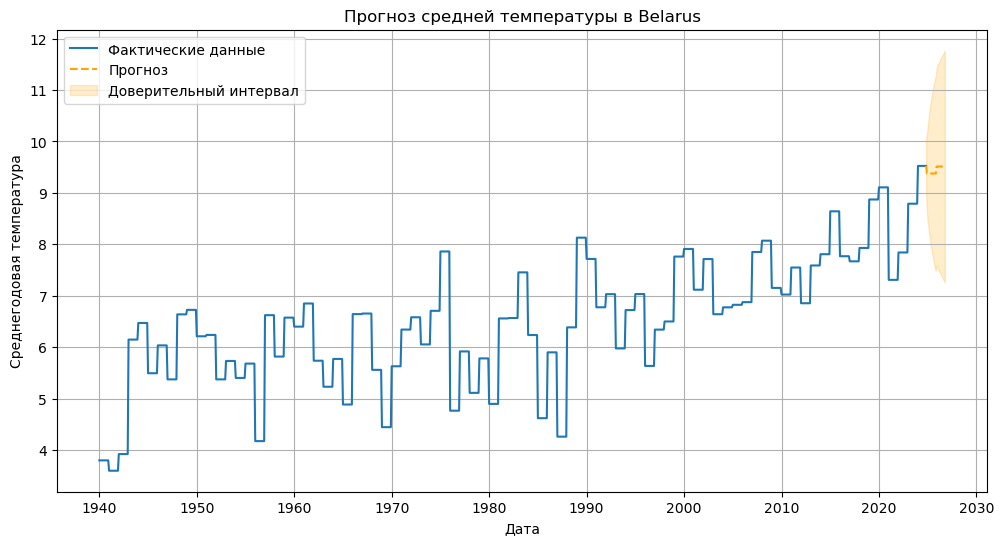

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Убедимся, что индекс имеет частоту
country_data = country_data.asfreq('MS')

# Обучение модели SARIMA
model = SARIMAX(country_data['Yearly average temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)  # Отключение логов оптимизации

# Прогноз на 24 месяца вперёд
forecast = results.get_forecast(steps=24)
forecast_index = pd.date_range(country_data.index[-1], periods=24, freq="MS")
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(country_data['Yearly average temp'], label="Фактические данные")
plt.plot(forecast_index, forecast_values, label="Прогноз", linestyle="--", color="orange")
plt.fill_between(forecast_index, 
                 confidence_intervals.iloc[:, 0],  # Нижняя граница
                 confidence_intervals.iloc[:, 1],  # Верхняя граница
                 color='orange', alpha=0.2, label="Доверительный интервал")
plt.title(f"Прогноз средней температуры в {country_name}")
plt.xlabel("Дата")
plt.ylabel("Среднегодовая температура")
plt.legend()
plt.grid(True)
plt.show()

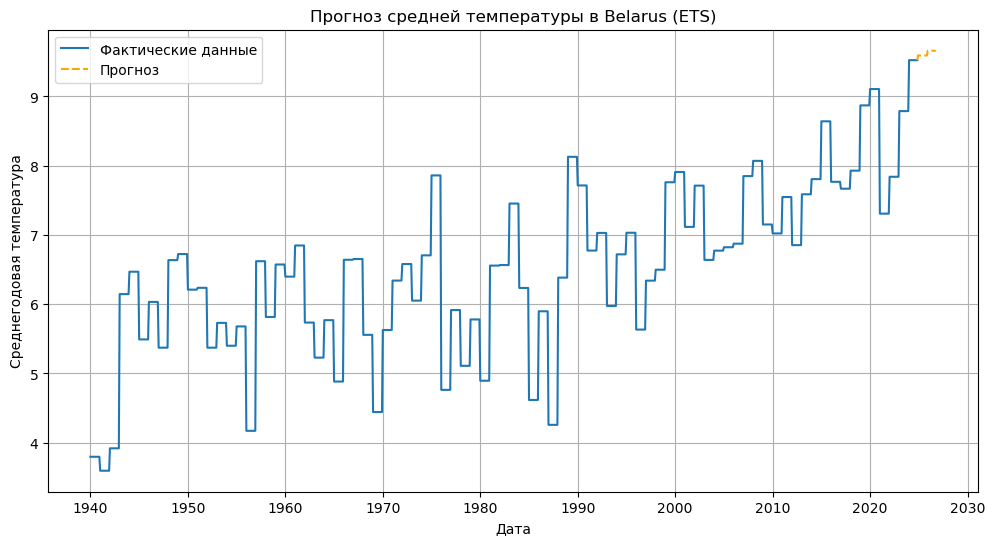

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Обучение модели ETS
model = ExponentialSmoothing(country_data['Yearly average temp'], 
                              trend="add", 
                              seasonal="add", 
                              seasonal_periods=12)
results = model.fit()

# Прогноз на 24 месяца вперёд
forecast_index = pd.date_range(country_data.index[-1], periods=24, freq="MS")
forecast_values = results.forecast(steps=24)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(country_data['Yearly average temp'], label="Фактические данные")
plt.plot(forecast_index, forecast_values, label="Прогноз", linestyle="--", color="orange")
plt.title(f"Прогноз средней температуры в {country_name} (ETS)")
plt.xlabel("Дата")
plt.ylabel("Среднегодовая температура")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
!pip install tensorflow

Epoch 1/80


/home/yana/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0562 
Epoch 2/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 3/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 4/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 5/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 6/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 7/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 8/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 9/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 10/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 11/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 12/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035   
Epoch 13/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 14/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 15/80
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 16/80
51/51 ━━━━━━━━

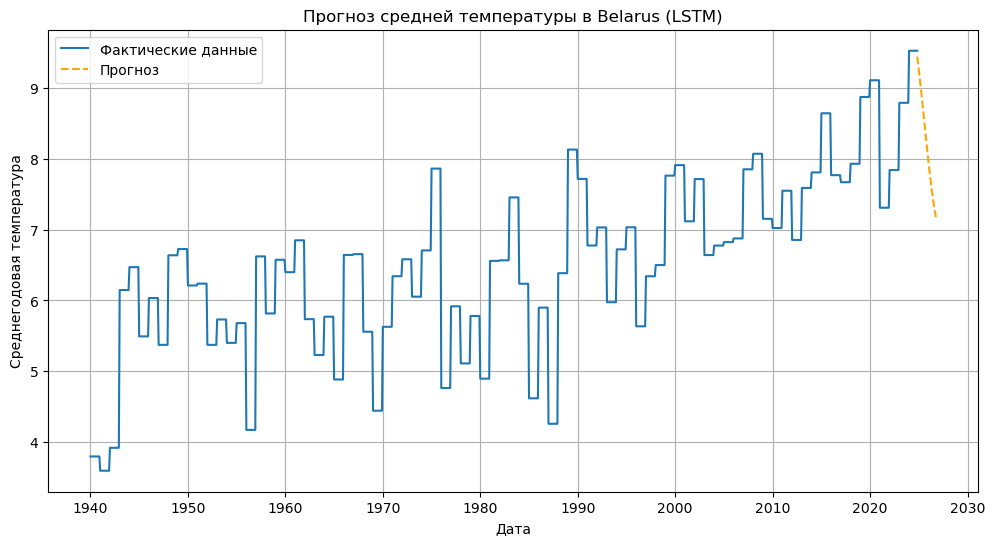

In [11]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Подготовка данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(country_data['Yearly average temp'].values.reshape(-1, 1))

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Длина окна (например, 12 месяцев)
X, y = create_sequences(scaled_data, seq_length)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Построение модели LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(X_train, y_train, epochs=80, batch_size=16, verbose=1)

# Прогнозирование
predictions = []
input_sequence = scaled_data[-seq_length:]  # Последняя последовательность для прогноза

for _ in range(24):  # Прогноз на 24 шага вперёд
    input_sequence = input_sequence.reshape((1, seq_length, 1))
    pred = model.predict(input_sequence)
    predictions.append(pred[0, 0])
    pred = np.array(pred).reshape(1, 1, 1)  # Преобразование pred в (1, 1, 1)
    input_sequence = np.append(input_sequence[:, 1:, :], pred, axis=1)

# Восстановление масштабов
forecast_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
forecast_index = pd.date_range(country_data.index[-1], periods=24, freq="MS")

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(country_data['Yearly average temp'], label="Фактические данные")
plt.plot(forecast_index, forecast_values, label="Прогноз", linestyle="--", color="orange")
plt.title(f"Прогноз средней температуры в {country_name} (LSTM)")
plt.xlabel("Дата")
plt.ylabel("Среднегодовая температура")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0671  
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6196 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3311 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1650 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1048 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0845 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0751 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0694 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0617 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0538 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0520 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0476 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0449 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

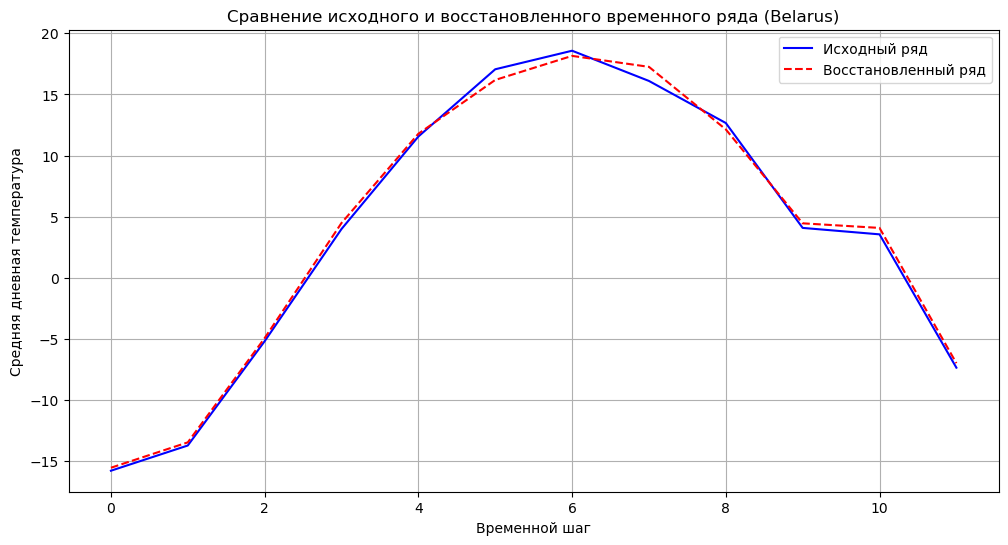

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Подготовка данных
data = country_data['Daily average temp'].values  # Берем данные о температуре
timesteps = 12  # Длина окна временного ряда (например, 12 месяцев)

# Создание последовательностей для автоэнкодера
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

X = create_sequences(data, timesteps)

# Нормализация данных
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

# Создание автоэнкодера
input_layer = Input(shape=(timesteps,))
encoded = Dense(32, activation='relu')(input_layer)  # Скрытое представление с 32 нейронами
decoded = Dense(timesteps, activation='linear')(encoded)  # Восстановление исходных данных

autoencoder = Model(input_layer, decoded)

# Компиляция модели
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Обучение автоэнкодера
autoencoder.fit(X_normalized, X_normalized, epochs=100, batch_size=32, shuffle=True)

# Использование обученного автоэнкодера для сжатия и восстановления временных рядов
encoded_data = autoencoder.predict(X_normalized)
restored_data = encoded_data * X_std + X_mean  # Восстановим данные в исходный масштаб

# Визуализация исходных и восстановленных данных
index = 0  # Индекс временного ряда для визуализации
plt.figure(figsize=(12, 6))
plt.plot(X[index], label='Исходный ряд', color='blue')
plt.plot(restored_data[index], label='Восстановленный ряд', color='red', linestyle='--')
plt.xlabel('Временной шаг')
plt.ylabel('Средняя дневная температура')
plt.legend()
plt.grid(True)
plt.title(f"Сравнение исходного и восстановленного временного ряда ({country_name})")
plt.show()

Epoch 1/10


/home/yana/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 - 1s - 30ms/step - loss: 0.1375
Epoch 2/10
21/21 - 0s - 3ms/step - loss: 0.0698
Epoch 3/10
21/21 - 0s - 3ms/step - loss: 0.0630
Epoch 4/10
21/21 - 0s - 3ms/step - loss: 0.0584
Epoch 5/10
21/21 - 0s - 3ms/step - loss: 0.0548
Epoch 6/10
21/21 - 0s - 3ms/step - loss: 0.0507
Epoch 7/10
21/21 - 0s - 3ms/step - loss: 0.0465
Epoch 8/10
21/21 - 0s - 3ms/step - loss: 0.0412
Epoch 9/10
21/21 - 0s - 3ms/step - loss: 0.0340
Epoch 10/10
21/21 - 0s - 3ms/step - loss: 0.0171
Epoch 1/10
21/21 - 1s - 31ms/step - loss: 0.2050
Epoch 2/10
21/21 - 0s - 3ms/step - loss: 0.0610
Epoch 3/10
21/21 - 0s - 3ms/step - loss: 0.0491
Epoch 4/10
21/21 - 0s - 3ms/step - loss: 0.0424
Epoch 5/10
21/21 - 0s - 3ms/step - loss: 0.0367
Epoch 6/10
21/21 - 0s - 3ms/step - loss: 0.0311
Epoch 7/10
21/21 - 0s - 3ms/step - loss: 0.0255
Epoch 8/10
21/21 - 0s - 3ms/step - loss: 0.0192
Epoch 9/10
21/21 - 0s - 3ms/step - loss: 0.0125
Epoch 10/10
21/21 - 0s - 3ms/step - loss: 0.0072
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━

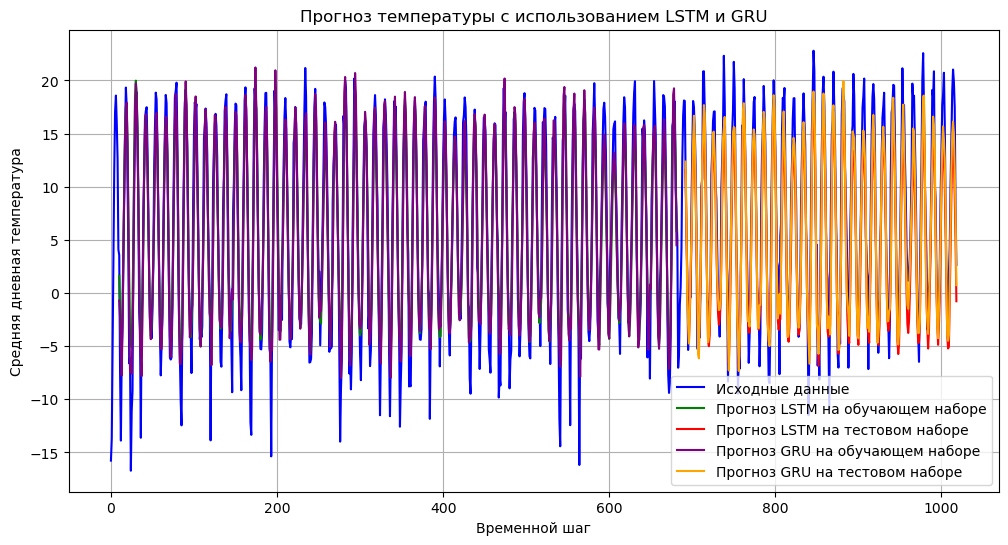

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from sklearn.model_selection import train_test_split

# Предполагаем, что country_data содержит столбец 'Daily average temp'
# Используем данные о температуре
data = country_data['Daily average temp'].values

# Масштабируем данные в диапазон [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Разделяем данные на обучающий и тестовый наборы (например, 67% на обучение, 33% на тест)
train_size = int(len(data_scaled) * 0.67)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Функция для создания датасета с лагами
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10  # Количество временных шагов (лагов)

# Создаем обучающие и тестовые данные
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Подготовка данных в формате (кол-во примеров, временные шаги, признаки)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создаем модель LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(look_back, 1)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель LSTM
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

# Создаем модель GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, input_shape=(look_back, 1)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель GRU
model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

# Прогнозы для обучающего и тестового наборов
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

# Инвертируем масштабирование данных
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

# Визуализируем прогнозы
train_plot_lstm = np.empty_like(data_scaled)
train_plot_lstm[:] = np.nan
train_plot_lstm[look_back:len(train_predict_lstm) + look_back, 0] = train_predict_lstm[:, 0]

test_plot_lstm = np.empty_like(data_scaled)
test_plot_lstm[:] = np.nan
offset = len(train_predict_lstm) + (look_back * 2)
test_plot_lstm[offset:len(test_predict_lstm) + offset, 0] = test_predict_lstm[:, 0]

train_plot_gru = np.empty_like(data_scaled)
train_plot_gru[:] = np.nan
train_plot_gru[look_back:len(train_predict_gru) + look_back, 0] = train_predict_gru[:, 0]

test_plot_gru = np.empty_like(data_scaled)
test_plot_gru[:] = np.nan
offset = len(train_predict_gru) + (look_back * 2)
test_plot_gru[offset:len(test_predict_gru) + offset, 0] = test_predict_gru[:, 0]

# Визуализируем результаты
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Исходные данные', color='blue')
plt.plot(train_plot_lstm, label='Прогноз LSTM на обучающем наборе', color='green')
plt.plot(test_plot_lstm, label='Прогноз LSTM на тестовом наборе', color='red')
plt.plot(train_plot_gru, label='Прогноз GRU на обучающем наборе', color='purple')
plt.plot(test_plot_gru, label='Прогноз GRU на тестовом наборе', color='orange')
plt.xlabel('Временной шаг')
plt.ylabel('Средняя дневная температура')
plt.legend()
plt.grid(True)
plt.title('Прогноз температуры с использованием LSTM и GRU')
plt.show()

Epoch 1/10


/home/yana/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 - 1s - 29ms/step - loss: 0.0762
Epoch 2/10
21/21 - 0s - 3ms/step - loss: 0.0142
Epoch 3/10
21/21 - 0s - 3ms/step - loss: 0.0110
Epoch 4/10
21/21 - 0s - 3ms/step - loss: 0.0103
Epoch 5/10
21/21 - 0s - 3ms/step - loss: 0.0098
Epoch 6/10
21/21 - 0s - 3ms/step - loss: 0.0093
Epoch 7/10
21/21 - 0s - 3ms/step - loss: 0.0089
Epoch 8/10
21/21 - 0s - 3ms/step - loss: 0.0087
Epoch 9/10
21/21 - 0s - 3ms/step - loss: 0.0081
Epoch 10/10
21/21 - 0s - 3ms/step - loss: 0.0076
Epoch 1/10
21/21 - 1s - 30ms/step - loss: 0.0789
Epoch 2/10
21/21 - 0s - 3ms/step - loss: 0.0138
Epoch 3/10
21/21 - 0s - 4ms/step - loss: 0.0097
Epoch 4/10
21/21 - 0s - 3ms/step - loss: 0.0081
Epoch 5/10
21/21 - 0s - 3ms/step - loss: 0.0070
Epoch 6/10
21/21 - 0s - 4ms/step - loss: 0.0061
Epoch 7/10
21/21 - 0s - 3ms/step - loss: 0.0054
Epoch 8/10
21/21 - 0s - 3ms/step - loss: 0.0049
Epoch 9/10
21/21 - 0s - 3ms/step - loss: 0.0046
Epoch 10/10
21/21 - 0s - 3ms/step - loss: 0.0044
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━

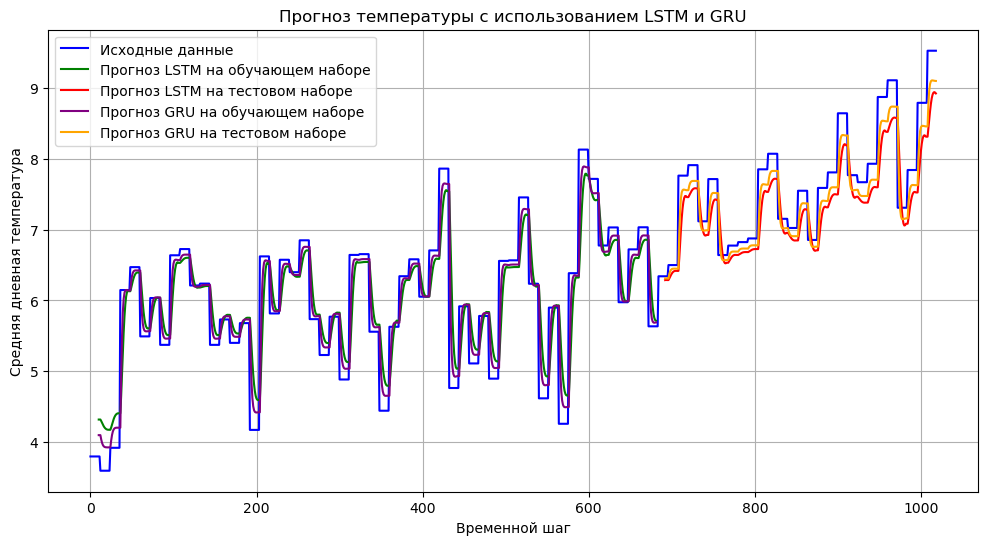

In [14]:
data = country_data['Yearly average temp'].values

# Масштабируем данные в диапазон [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Разделяем данные на обучающий и тестовый наборы (например, 67% на обучение, 33% на тест)
train_size = int(len(data_scaled) * 0.67)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Функция для создания датасета с лагами
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10  # Количество временных шагов (лагов)

# Создаем обучающие и тестовые данные
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Подготовка данных в формате (кол-во примеров, временные шаги, признаки)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создаем модель LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(look_back, 1)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель LSTM
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

# Создаем модель GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, input_shape=(look_back, 1)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель GRU
model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

# Прогнозы для обучающего и тестового наборов
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

# Инвертируем масштабирование данных
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

# Визуализируем прогнозы
train_plot_lstm = np.empty_like(data_scaled)
train_plot_lstm[:] = np.nan
train_plot_lstm[look_back:len(train_predict_lstm) + look_back, 0] = train_predict_lstm[:, 0]

test_plot_lstm = np.empty_like(data_scaled)
test_plot_lstm[:] = np.nan
offset = len(train_predict_lstm) + (look_back * 2)
test_plot_lstm[offset:len(test_predict_lstm) + offset, 0] = test_predict_lstm[:, 0]

train_plot_gru = np.empty_like(data_scaled)
train_plot_gru[:] = np.nan
train_plot_gru[look_back:len(train_predict_gru) + look_back, 0] = train_predict_gru[:, 0]

test_plot_gru = np.empty_like(data_scaled)
test_plot_gru[:] = np.nan
offset = len(train_predict_gru) + (look_back * 2)
test_plot_gru[offset:len(test_predict_gru) + offset, 0] = test_predict_gru[:, 0]

# Визуализируем результаты
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Исходные данные', color='blue')
plt.plot(train_plot_lstm, label='Прогноз LSTM на обучающем наборе', color='green')
plt.plot(test_plot_lstm, label='Прогноз LSTM на тестовом наборе', color='red')
plt.plot(train_plot_gru, label='Прогноз GRU на обучающем наборе', color='purple')
plt.plot(test_plot_gru, label='Прогноз GRU на тестовом наборе', color='orange')
plt.xlabel('Временной шаг')
plt.ylabel('Средняя дневная температура')
plt.legend()
plt.grid(True)
plt.title('Прогноз температуры с использованием LSTM и GRU')
plt.show()

Epoch 1/50


/home/yana/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2107 - val_loss: 0.0712
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0641 - val_loss: 0.0421
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0375 - val_loss: 0.0132
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0061
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0043


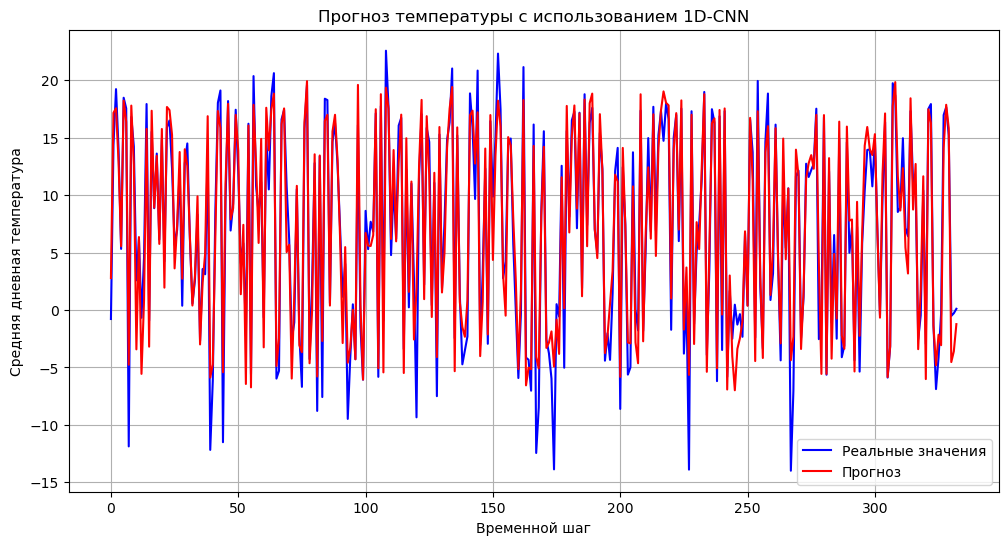

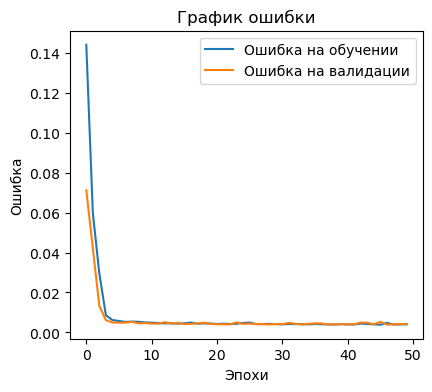

In [15]:
data = country_data['Daily average temp'].values

# Нормализация данных
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Создание набора данных с лагами (например, для прогноза на 1 шаг вперед)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10  # Количество временных шагов
X, y = create_dataset(data_scaled, look_back)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Преобразуем данные для подачи в 1D-CNN (формат: [samples, timesteps, features])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Создание модели 1D-CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)  # Прогнозируем одно значение
])

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Прогноз на тестовых данных
y_pred = model.predict(X_test)

# Инвертируем масштабирование данных
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Реальные значения', color='blue')
plt.plot(y_pred_inverse, label='Прогноз', color='red')
plt.xlabel('Временной шаг')
plt.ylabel('Средняя дневная температура')
plt.legend()
plt.grid(True)
plt.title('Прогноз температуры с использованием 1D-CNN')
plt.show()

# Визуализация метрик обучения
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.title('График ошибки')

plt.show()

In [16]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


Эпоха 1/100, Потеря: 0.05233258754014969
Эпоха 2/100, Потеря: 2.1960060596466064
Эпоха 3/100, Потеря: 0.03768036887049675
Эпоха 4/100, Потеря: 0.6512843370437622
Эпоха 5/100, Потеря: 0.5795994997024536
Эпоха 6/100, Потеря: 0.207710862159729
Эпоха 7/100, Потеря: 0.026355504989624023
Эпоха 8/100, Потеря: 0.08197084069252014
Эпоха 9/100, Потеря: 0.19076469540596008
Эпоха 10/100, Потеря: 0.2072720229625702
Эпоха 11/100, Потеря: 0.16422368586063385
Эпоха 12/100, Потеря: 0.0885874405503273
Эпоха 13/100, Потеря: 0.038307156413793564
Эпоха 14/100, Потеря: 0.03781164437532425
Эпоха 15/100, Потеря: 0.06487180292606354
Эпоха 16/100, Потеря: 0.09279237687587738
Эпоха 17/100, Потеря: 0.10076646506786346
Эпоха 18/100, Потеря: 0.08328687399625778
Эпоха 19/100, Потеря: 0.06094078719615936
Эпоха 20/100, Потеря: 0.03872556611895561
Эпоха 21/100, Потеря: 0.03412385657429695
Эпоха 22/100, Потеря: 0.03320746123790741
Эпоха 23/100, Потеря: 0.041632670909166336
Эпоха 24/100, Потеря: 0.052288468927145004
Эпох

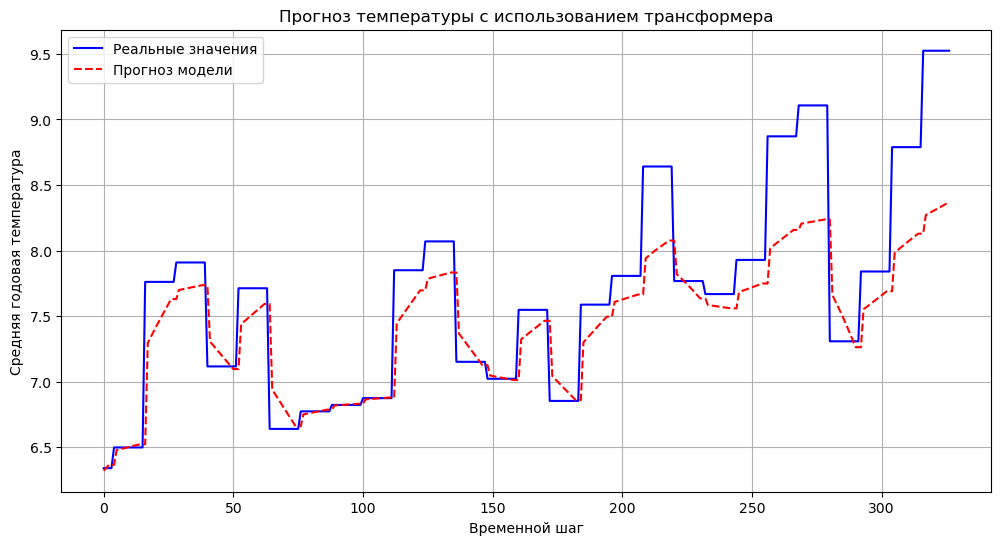

In [21]:
import torch
import torch.nn as nn


# Подготовка данных
data = country_data['Yearly average temp'].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

train_size = int(len(data_scaled) * 0.67)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout_prob):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(
            hidden_dim, num_heads, dim_feedforward=hidden_dim * 4, dropout=dropout_prob, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layer_norm(x)
        x = self.transformer_encoder(x)
        x = self.output_layer(x[:, -1, :])
        return x

input_dim = 1
output_dim = 1
num_layers = 4
num_heads = 4
hidden_dim = 64
dropout_prob = 0.1

model = TransformerTimeSeries(input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout_prob)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor.squeeze())
    loss.backward()
    optimizer.step()
    print(f"Эпоха {epoch + 1}/{epochs}, Потеря: {loss.item()}")

model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor).squeeze()

test_output = scaler.inverse_transform(test_output.numpy().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Реальные значения', color='blue')
plt.plot(test_output, label='Прогноз модели', color='red', linestyle="--")
plt.xlabel('Временной шаг')
plt.ylabel('Средняя годовая температура')
plt.title('Прогноз температуры с использованием трансформера')
plt.legend()
plt.grid(True)
plt.show()